# Inference demo

In this notebook we will run evaluation of the released models from the work [*Unsupervised Change Detection of Extreme Events Using ML On-Board*](http://arxiv.org/abs/2111.02995). This work was conducted at the [FDL Europe 2021](https://fdleurope.org/fdl-europe-2021) research accelerator program. 

The validation dataset contains 19 identified events with natural disasters. For each of these events we obtained 4 Sentinel-2 images prior to the event and 1 image after the event. Additionally, we created a manually derived change mask with the identified changes in the last image. This dataset is hosted in this [public Google Drive folder](https://drive.google.com/drive/folders/1VEf49IDYFXGKcfvMsfh33VSiyx5MpHEn?usp=sharing).

In this notebook we show how to run our released models to produce qualitative and quantitative results *(Note that in the paper these results were repeated and averaged over 5 runs)*.

# Get the data and prepare the environment

In [1]:
# Remember to run this notebook with GPU
!nvidia-smi

Wed Mar 30 14:54:42 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P8    35W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Install these libraries:

In [ ]:
# Install libraries relevant for Colab
!pip install --quiet --upgrade gdown
!pip install --quiet hydra-core==1.1.0 kornia rasterio wandb pandas seaborn sklearn
!pip install --quiet pytorch_lightning==1.3.8

In [3]:
!pip install matplotlib==3.5.1 numpy==1.21.1 Pillow==8.3.1
# please restart the runtime after these!

     |████████████████████████████████| 11.2 MB 5.2 MB/s 
     |████████████████████████████████| 15.7 MB 19.1 MB/s 
     |████████████████████████████████| 3.0 MB 13.2 MB/s 
     |████████████████████████████████| 899 kB 27.0 MB/s 
  Attempting uninstall: Pillow
    Found existing installation: Pillow 7.1.2
    Uninstalling Pillow-7.1.2:
      Successfully uninstalled Pillow-7.1.2
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.5
    Uninstalling numpy-1.21.5:
      Successfully uninstalled numpy-1.21.5
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0 requires tf-estimator-nightly==2.8.0.dev2021122109, which is not installed.
datascience 0.10.6 requires 

After restarting the runtime, continue with:

In [ ]:
!git clone https://github.com/spaceml-org/RaVAEn.git

In [2]:
# pretrained models
!mkdir /content/pretrained
%cd /content/pretrained

# download one model (23MB) setting with the code below (or alternatively download all the released models (138MB) from https://drive.google.com/file/d/12AwpGu7El1FWP7ErFBQ9sfuTzl2L-dT4/view?usp=sharing )
!gdown https://drive.google.com/uc?id=1LcOMmWxYSBUrH_HS747FGkhr2ZuS_y8v -O pretrained_small.zip
!unzip -q pretrained_small.zip
!rm pretrained_small.zip

%cd /content/

/content/pretrained
Downloading...
From: https://drive.google.com/uc?id=1LcOMmWxYSBUrH_HS747FGkhr2ZuS_y8v
To: /content/pretrained/pretrained_small.zip
100% 24.8M/24.8M [00:00<00:00, 76.3MB/s]
/content


## Get the data

If you’re running this tutorial in **Google Colab** you need to *'add a shortcut to your Google Drive’* from our [public Google Drive folder](https://drive.google.com/drive/folders/1VEf49IDYFXGKcfvMsfh33VSiyx5MpHEn?usp=sharing) and mount that directory with the following code:

In [3]:
from google.colab import drive
import os
drive.mount('/content/drive')

public_folder = '/content/drive/My Drive/FDL21_RaVAEn_datasets'
assert os.path.exists(public_folder), "Add a shortcut to the publice Google Drive folder: https://drive.google.com/drive/folders/1VEf49IDYFXGKcfvMsfh33VSiyx5MpHEn?usp=sharing"

Mounted at /content/drive


If you're running in a **jupyter notebook** you should download the data from the [public Google Drive folder](https://drive.google.com/drive/folders/1VEf49IDYFXGKcfvMsfh33VSiyx5MpHEn?usp=sharing) manually or, alternatively you can try the `gdown` package for programatically download data from the Google Drive.

In [ ]:
# Alternatively download these with gdown:
"""
#!gdown https://drive.google.com/uc?id=1UCNnxaL9pQSkkZQx0aDEWQL0UBXPXkv0 -O fires.zip
#!gdown https://drive.google.com/uc?id=1CbNGrpK66Hos_TtOEut510k7CSHvSwkl -O landslides.zip
#!gdown https://drive.google.com/uc?id=1VP3SYgh3bj6uPa4r_bKP-5zFP3JdGin8 -O hurricanes.zip
!gdown https://drive.google.com/uc?id=1scjd4gIB_eiNS-CsOyb7Q8rYWnl9TM-L -O floods.zip
public_folder = "." # because we downloaded these locally
"""

## Unzip the data

The following two cells unzips the data and list the ground truth files with the manually identified changes.

In [ ]:
from glob import glob
files_to_extract = sorted(glob(os.path.join(public_folder,"*.zip")))
print("All:",files_to_extract) # feel free to subset these, for example:

# Example: Selecting only floods:
# files_to_extract = ['/content/drive/My Drive/FDL21_RaVAEn_datasets/floods.zip']
# print("Selected:",files_to_extract)

In [6]:
import zipfile
from tqdm import tqdm

dataset_folder = "./datasets"
os.makedirs(dataset_folder, exist_ok=True)

for zip_files in tqdm(files_to_extract):
  with zipfile.ZipFile(zip_files, "r") as zip_ref:
    zip_ref.extractall(dataset_folder)
    zip_ref.close()

100%|██████████| 1/1 [00:49<00:00, 49.93s/it]


# Run the inference

We prepare the configs and run evaluation with the downloaded released model and one of the datasets (for example the *fires* event). For best results visualization we recommend logging into **Weights & Biases**, however some basic data predictions will be saved locally as well.

In [ ]:
%cd /content/RaVAEn/
!ls

In [8]:
# Edit the config programatically for Colab
p = """
---
entity: "mlpayloads"

log_dir: "/content/results"
cache_dir: "/content/cache"
"""

c = """text_file = open("config/config.yaml", "w+");text_file.write(p);text_file.close()""" 
exec(c)

In [9]:
# Just to double-check
!cat config/config.yaml
"""
Should show:
log_dir: "/content/results"
cache_dir: "/content/cache"
"""
pass


---
entity: "mlpayloads"

log_dir: "/content/results"
cache_dir: "/content/cache"


In [10]:
!mkdir /content/results
!mkdir /content/results/wandb/
!mkdir /content/results/cache/

In [11]:
# ===== Parameters to adjust =====
# Note: adjust these to where you downloaded the datasets and the pretrained models

event="floods" # change this accordingly to which dataset you downloaded
checkpoint="/content/pretrained/D_train_VAE_128small/3k0vhd2o/checkpoints/epoch_00-step_29653.ckpt"
dataset_root_folder = "/content/datasets/" + event

name="VAE_128small_3k0vhd2o_epoch0___DemoInferenceOnColab"

# ===== Parameters to keep the same ======

evaluation="vae_paper"
training="simple_vae"
module="deeper_vae"
plot_sequences="true"

# ========================================

!python3 -m scripts.evaluate_model \
    +dataset=floods_evaluation \
    ++dataset.root_folder=$dataset_root_folder \
    +training=$training \
    +normalisation=log_scale \
    +channels=high_res \
    +module=$module \
    +checkpoint=$checkpoint \
    +project="FDL21_RaVAEn_model_128small" \
    +evaluation=$evaluation \
    ++evaluation.plot_sequences=$plot_sequences \
    +name="{name}_{event}" \
    +dataset.test_overlap=[0,0] module.model_cls_args.latent_dim=128 module.model_cls_args.extra_depth_on_scale=0 module.model_cls_args.hidden_channels=[16,32,64] \
    ++evaluation.save_plots_locally=true \
    training.num_workers=2 training.batch_size_train=64 training.batch_size_valid=64 training.batch_size_test=64

    # the last few args set the same architecture as the one we used when training
    # and some hw specs settings:
    # training.num_workers=2 training.batch_size_train=64 training.batch_size_valid=64 training.batch_size_test=64


LATENT SPACE size: 128
Loading checkpoint /content/pretrained/D_train_VAE_128small/3k0vhd2o/checkpoints/epoch_00-step_29653.ckpt
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/saving.py:349: RuntimeWarning: Missing Tags: /content/pretrained/D_train_VAE_128small/3k0vhd2o/hparams.yaml.
  rank_zero_warn(f"Missing Tags: {config_yaml}.", RuntimeWarning)

LATENT SPACE size: 128
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice: 2
wandb: You chose 'Use an existing W&B account'
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Tracking run with wandb version 0.12.11
wandb: Run data is saved locally in /content/results/wandb/run-20220330_145943-gt1zk9tf
wandb: Run `wandb offline` to turn off syncing.
wandb:

In [ ]:
# Time estimation: for the "floods" dataset (~2.45GB), the validation takes approximately
# 40 mins (this is because we are running and comparing many methods, for details 
# on deployed performance read the paper). You can also access the intermediate
# results in the outputs/ folder or on the wandb directly...

# 3 Results

Results are best to be observed on the generated Wandb page, however there are also local files saved which we can observe.

In [12]:
!ls outputs/*.csv

outputs/000_stats.csv  outputs/002_stats.csv
outputs/001_stats.csv  outputs/003_stats.csv


Note that we have results corresponding to all of the above csv files. Just select one by setting ``` index = 0 ``` (1,2, etc...).



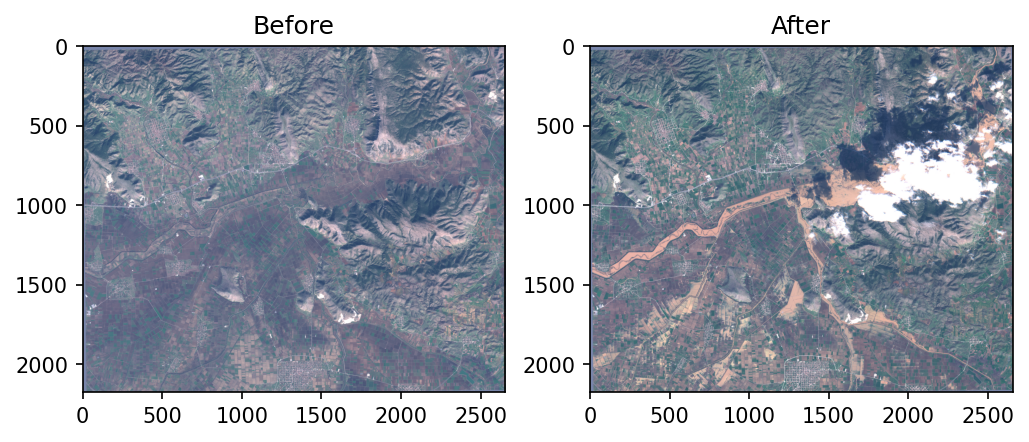

In [22]:
import matplotlib.pyplot as plt

# Select the index of the desired event
index = 1
#index = 0

# Event visualization
plt.figure(figsize=(8, 6), dpi=150)

plt.subplot(1, 2, 1)
img = plt.imread("./outputs/"+str(index).zfill(3)+"_1_before.png")
plt.imshow(img)
plt.gca().set_title('Before')

plt.subplot(1, 2, 2)
img = plt.imread("./outputs/"+str(index).zfill(3)+"_2_after.png")
plt.imshow(img)
plt.gca().set_title('After')

plt.show()

Ground truth


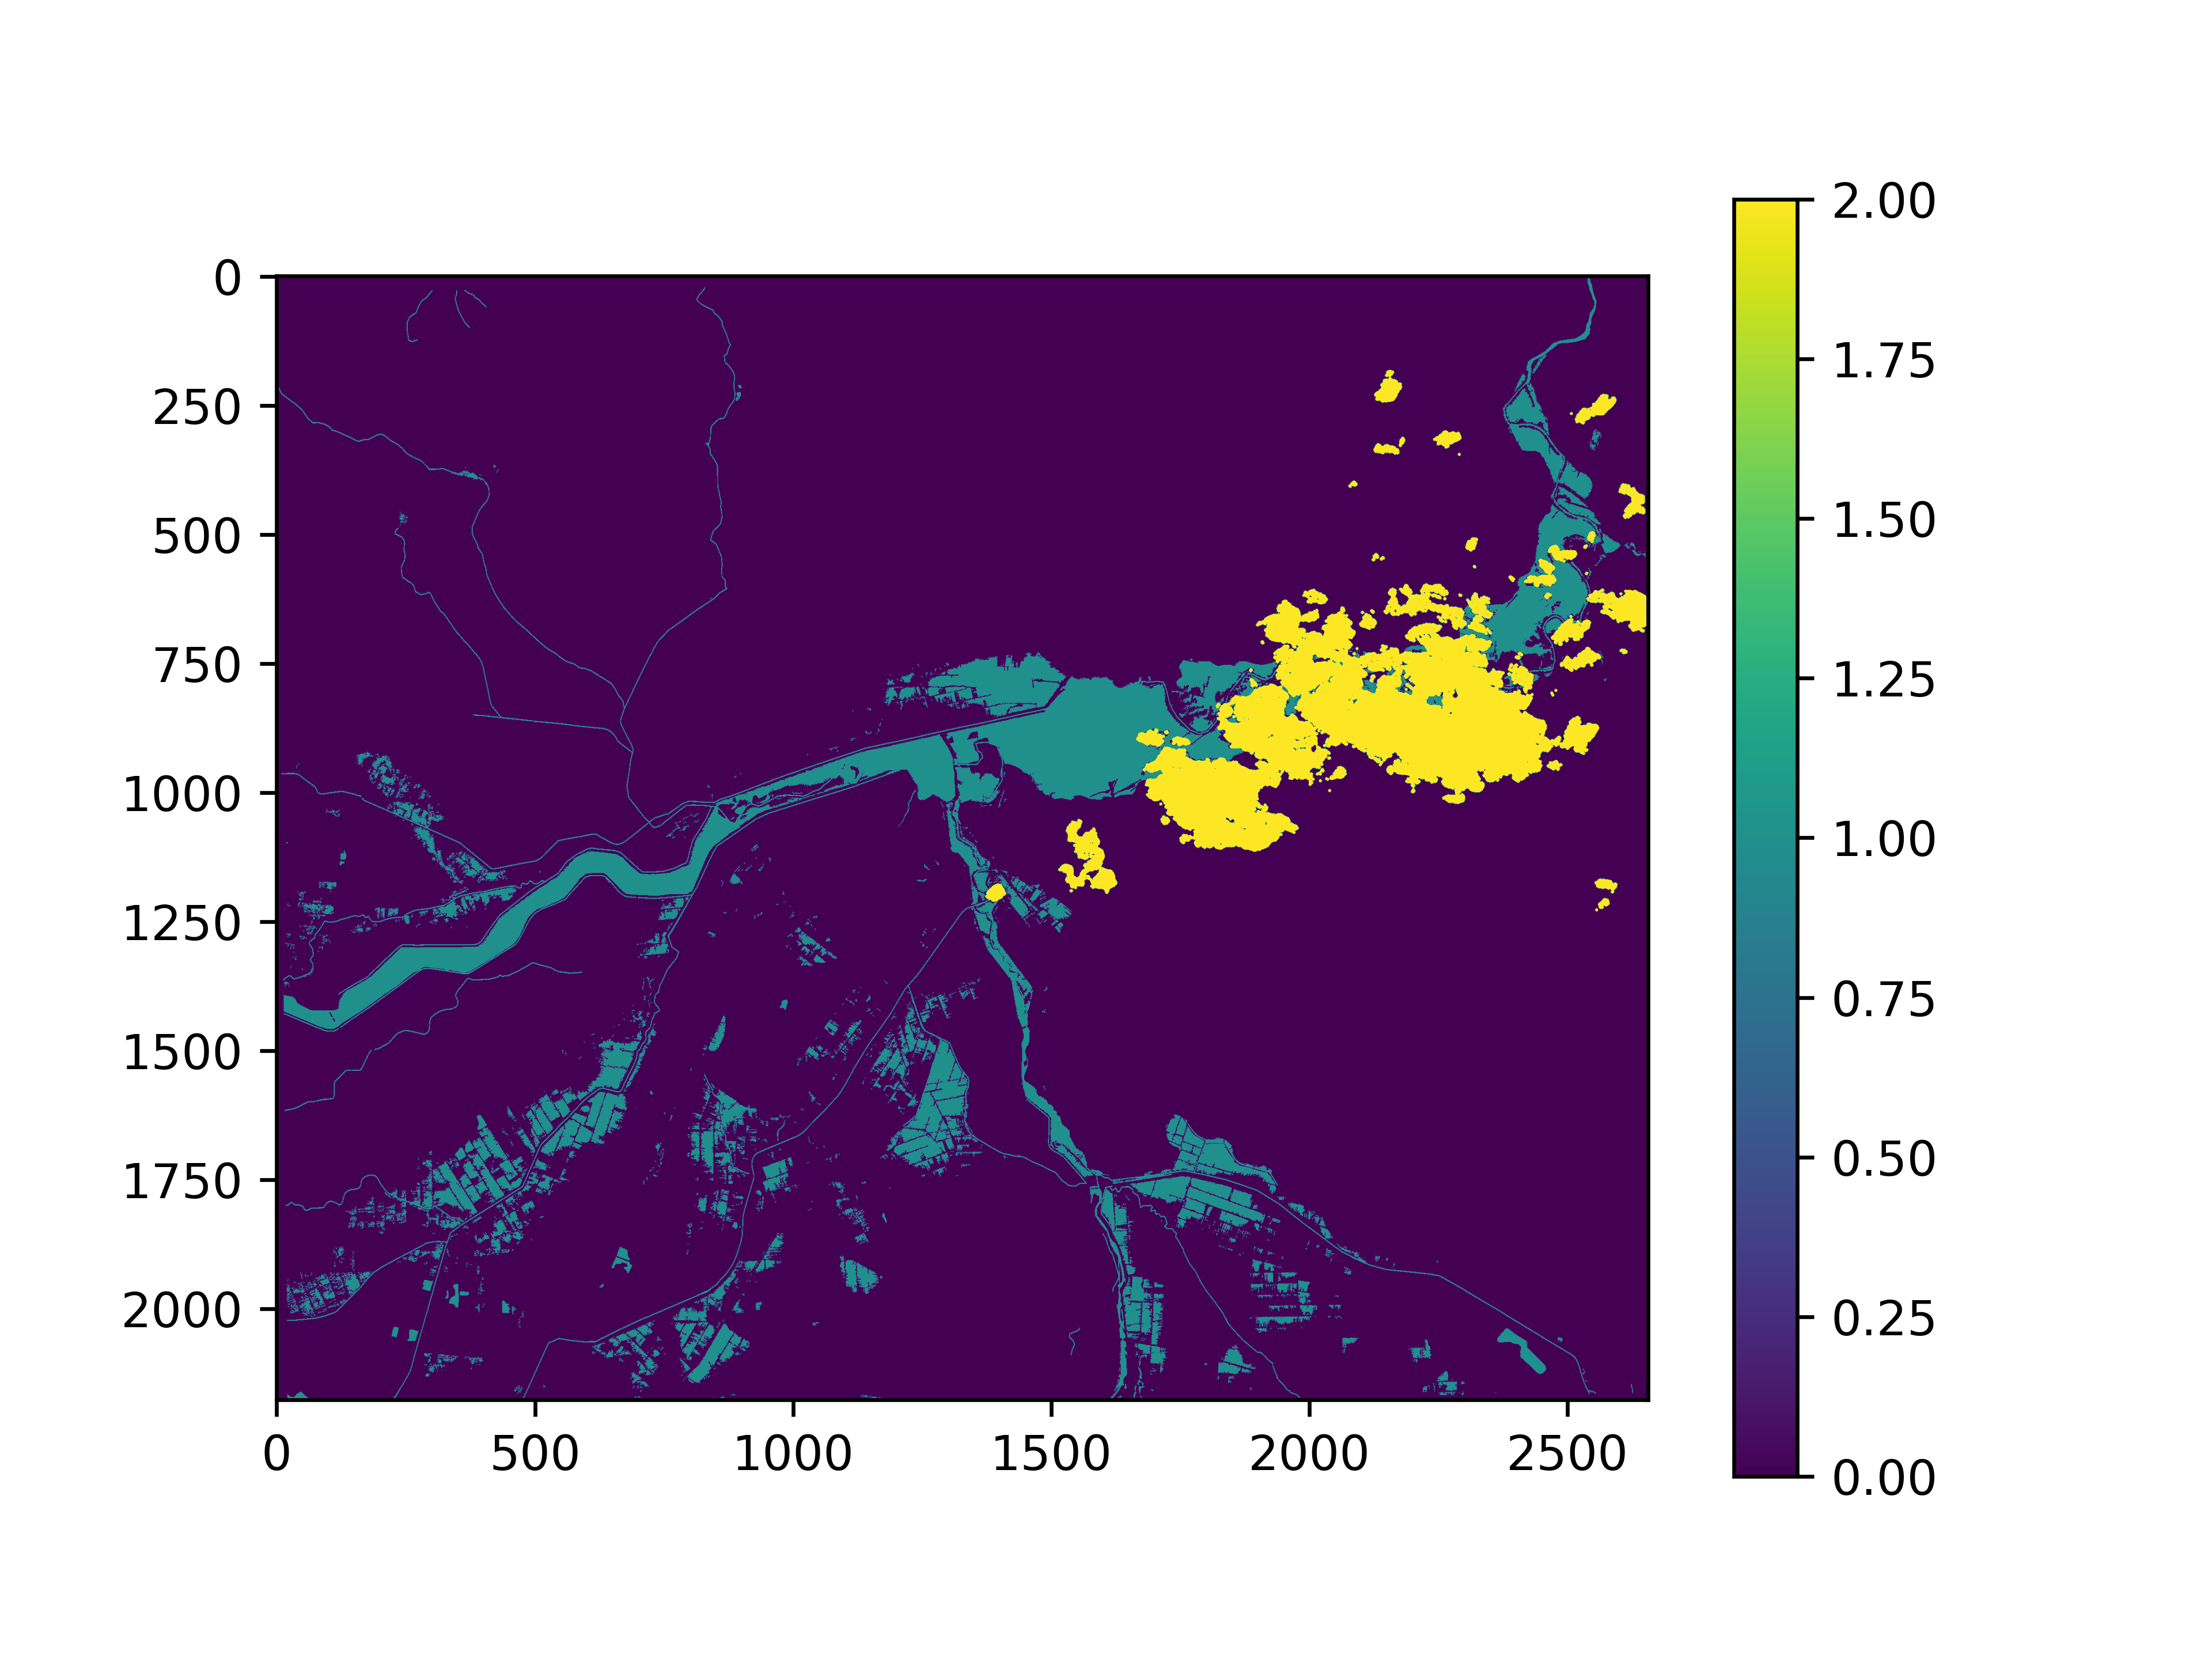

In [21]:
# Event visualization
from IPython.display import Image
print('Ground truth')
Image("./outputs/"+str(index).zfill(3)+"_3_change mask.png",
      height=400)

Baseline (pixel values in cosine distance, with memory 3)


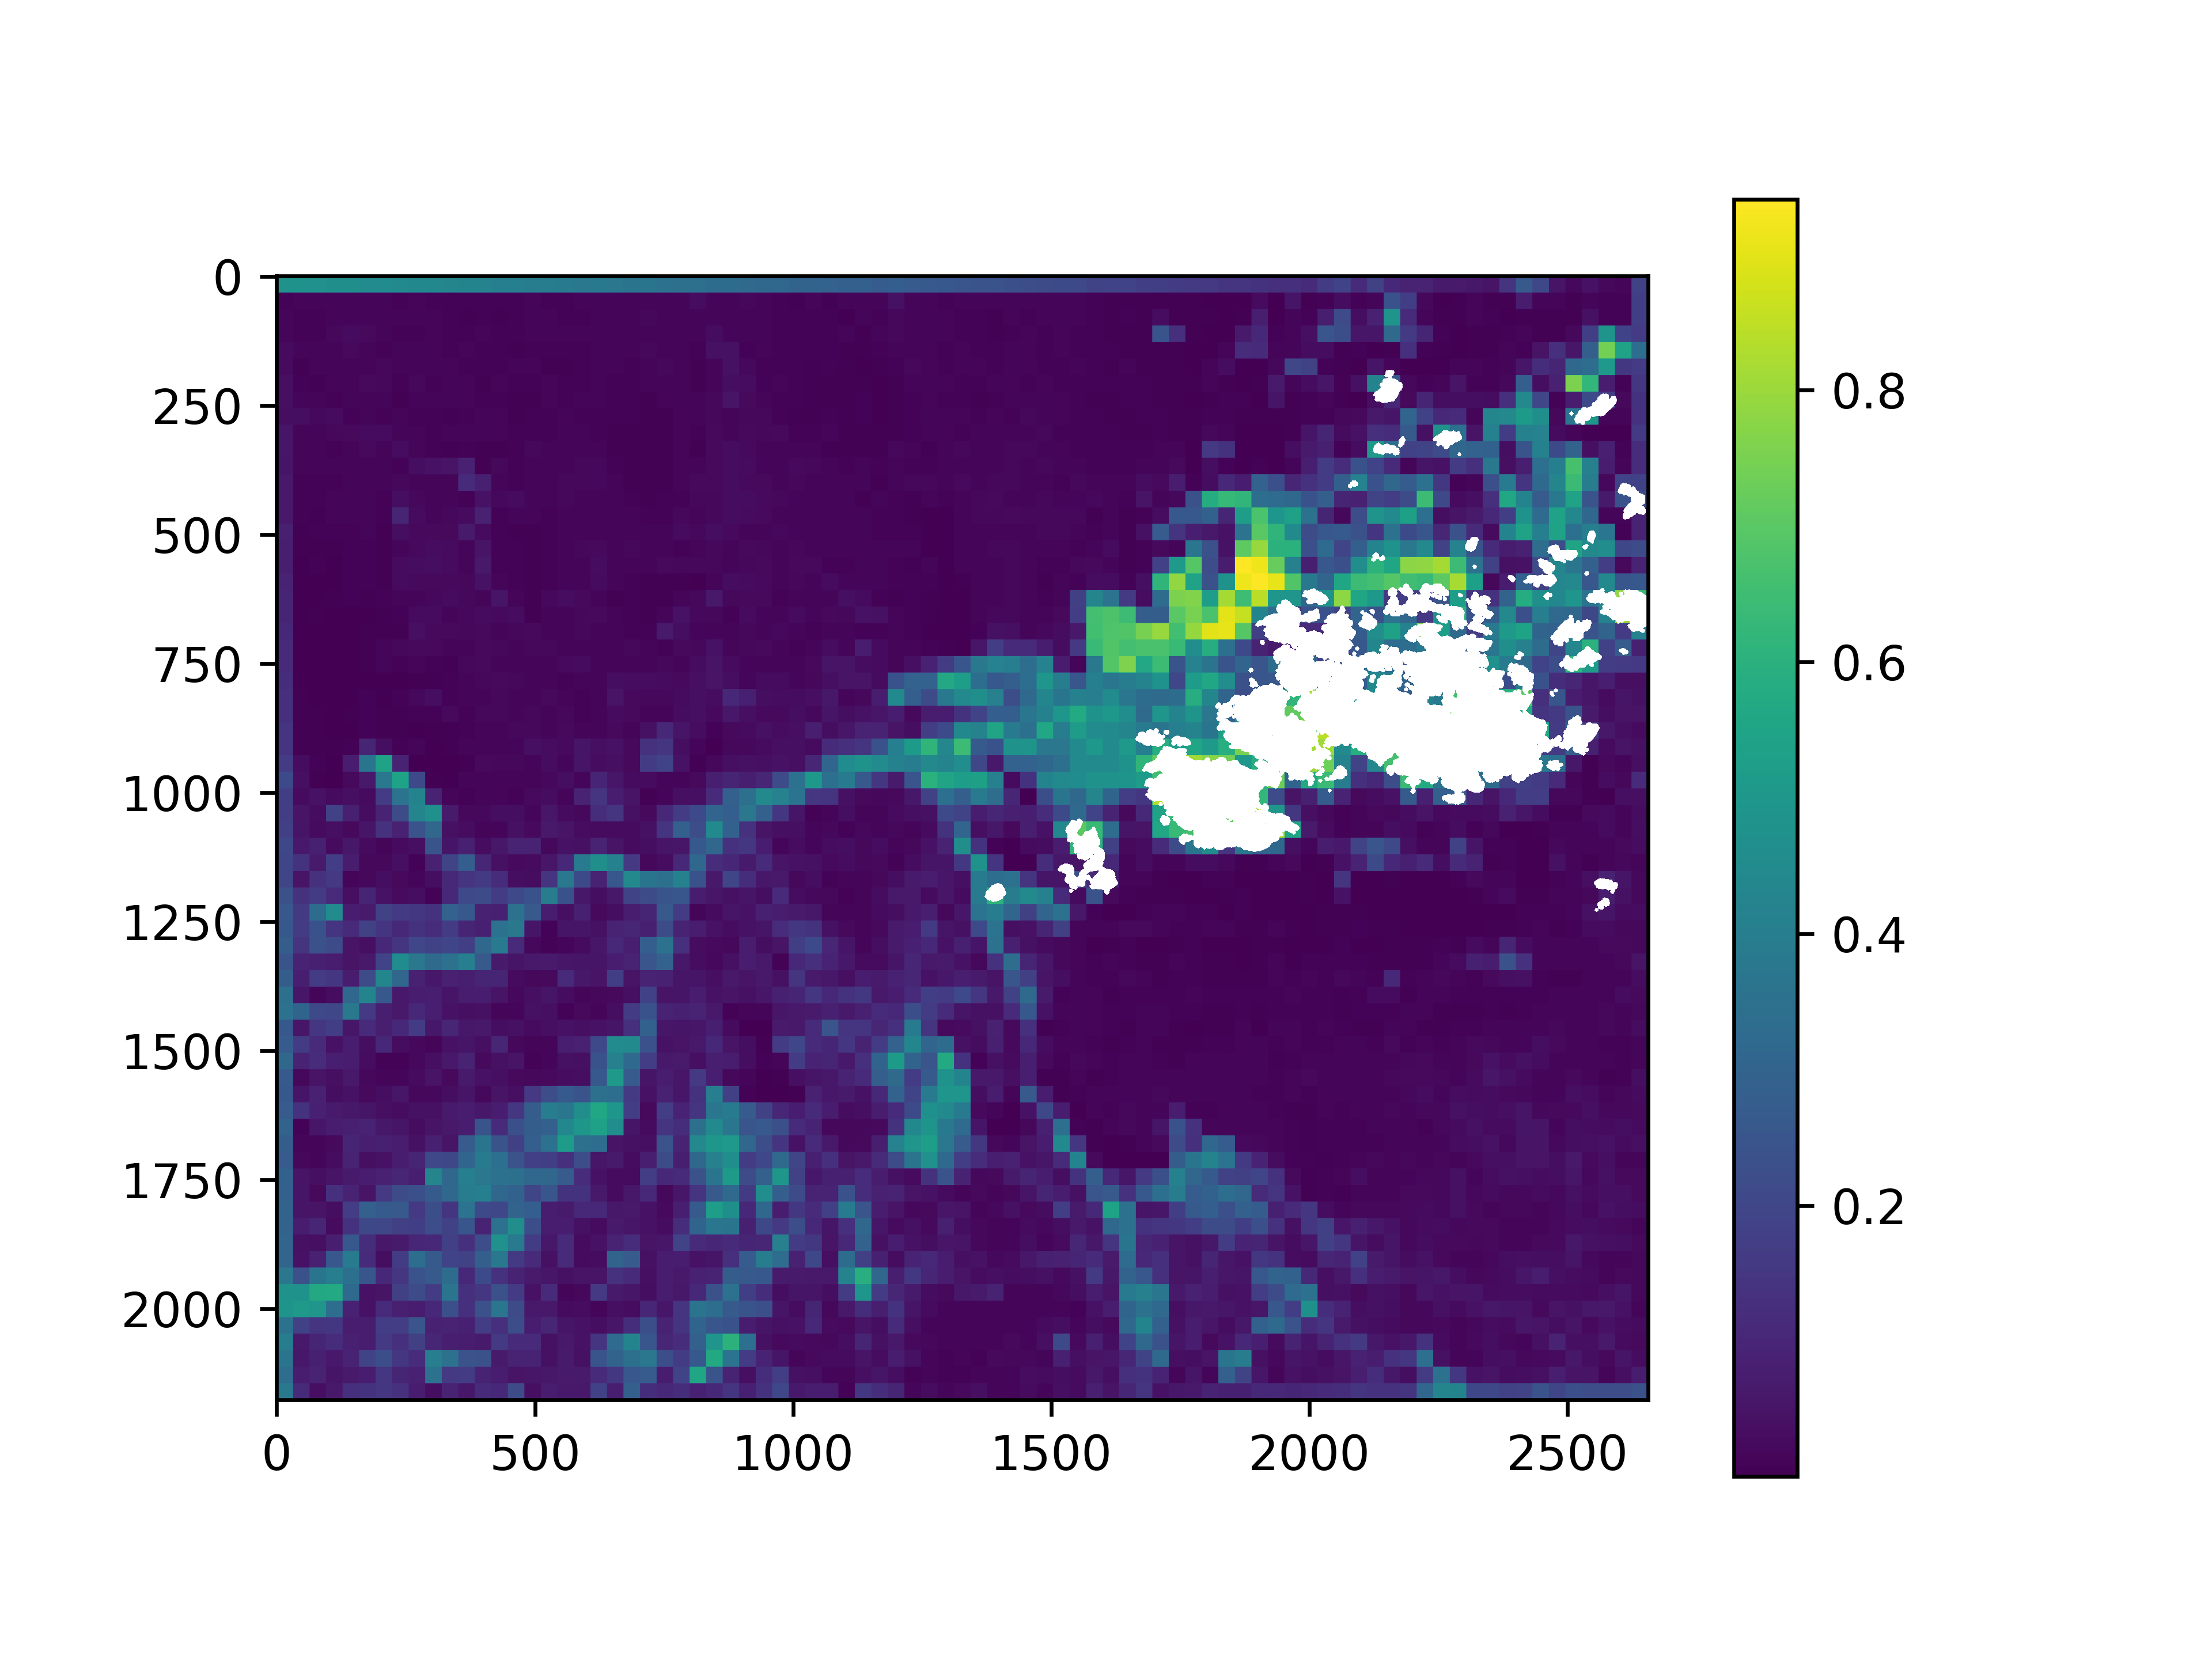

In [20]:
# Event visualization
from IPython.display import Image
print('Baseline (pixel values in cosine distance, with memory 3)')
Image("./outputs/"+str(index).zfill(3)+"_10_cos_pixel | memory 3 | 32x32 - mean.png",
      height=400)

RAVAEN (cosine distance of learned embedded tiles, with memory 3)


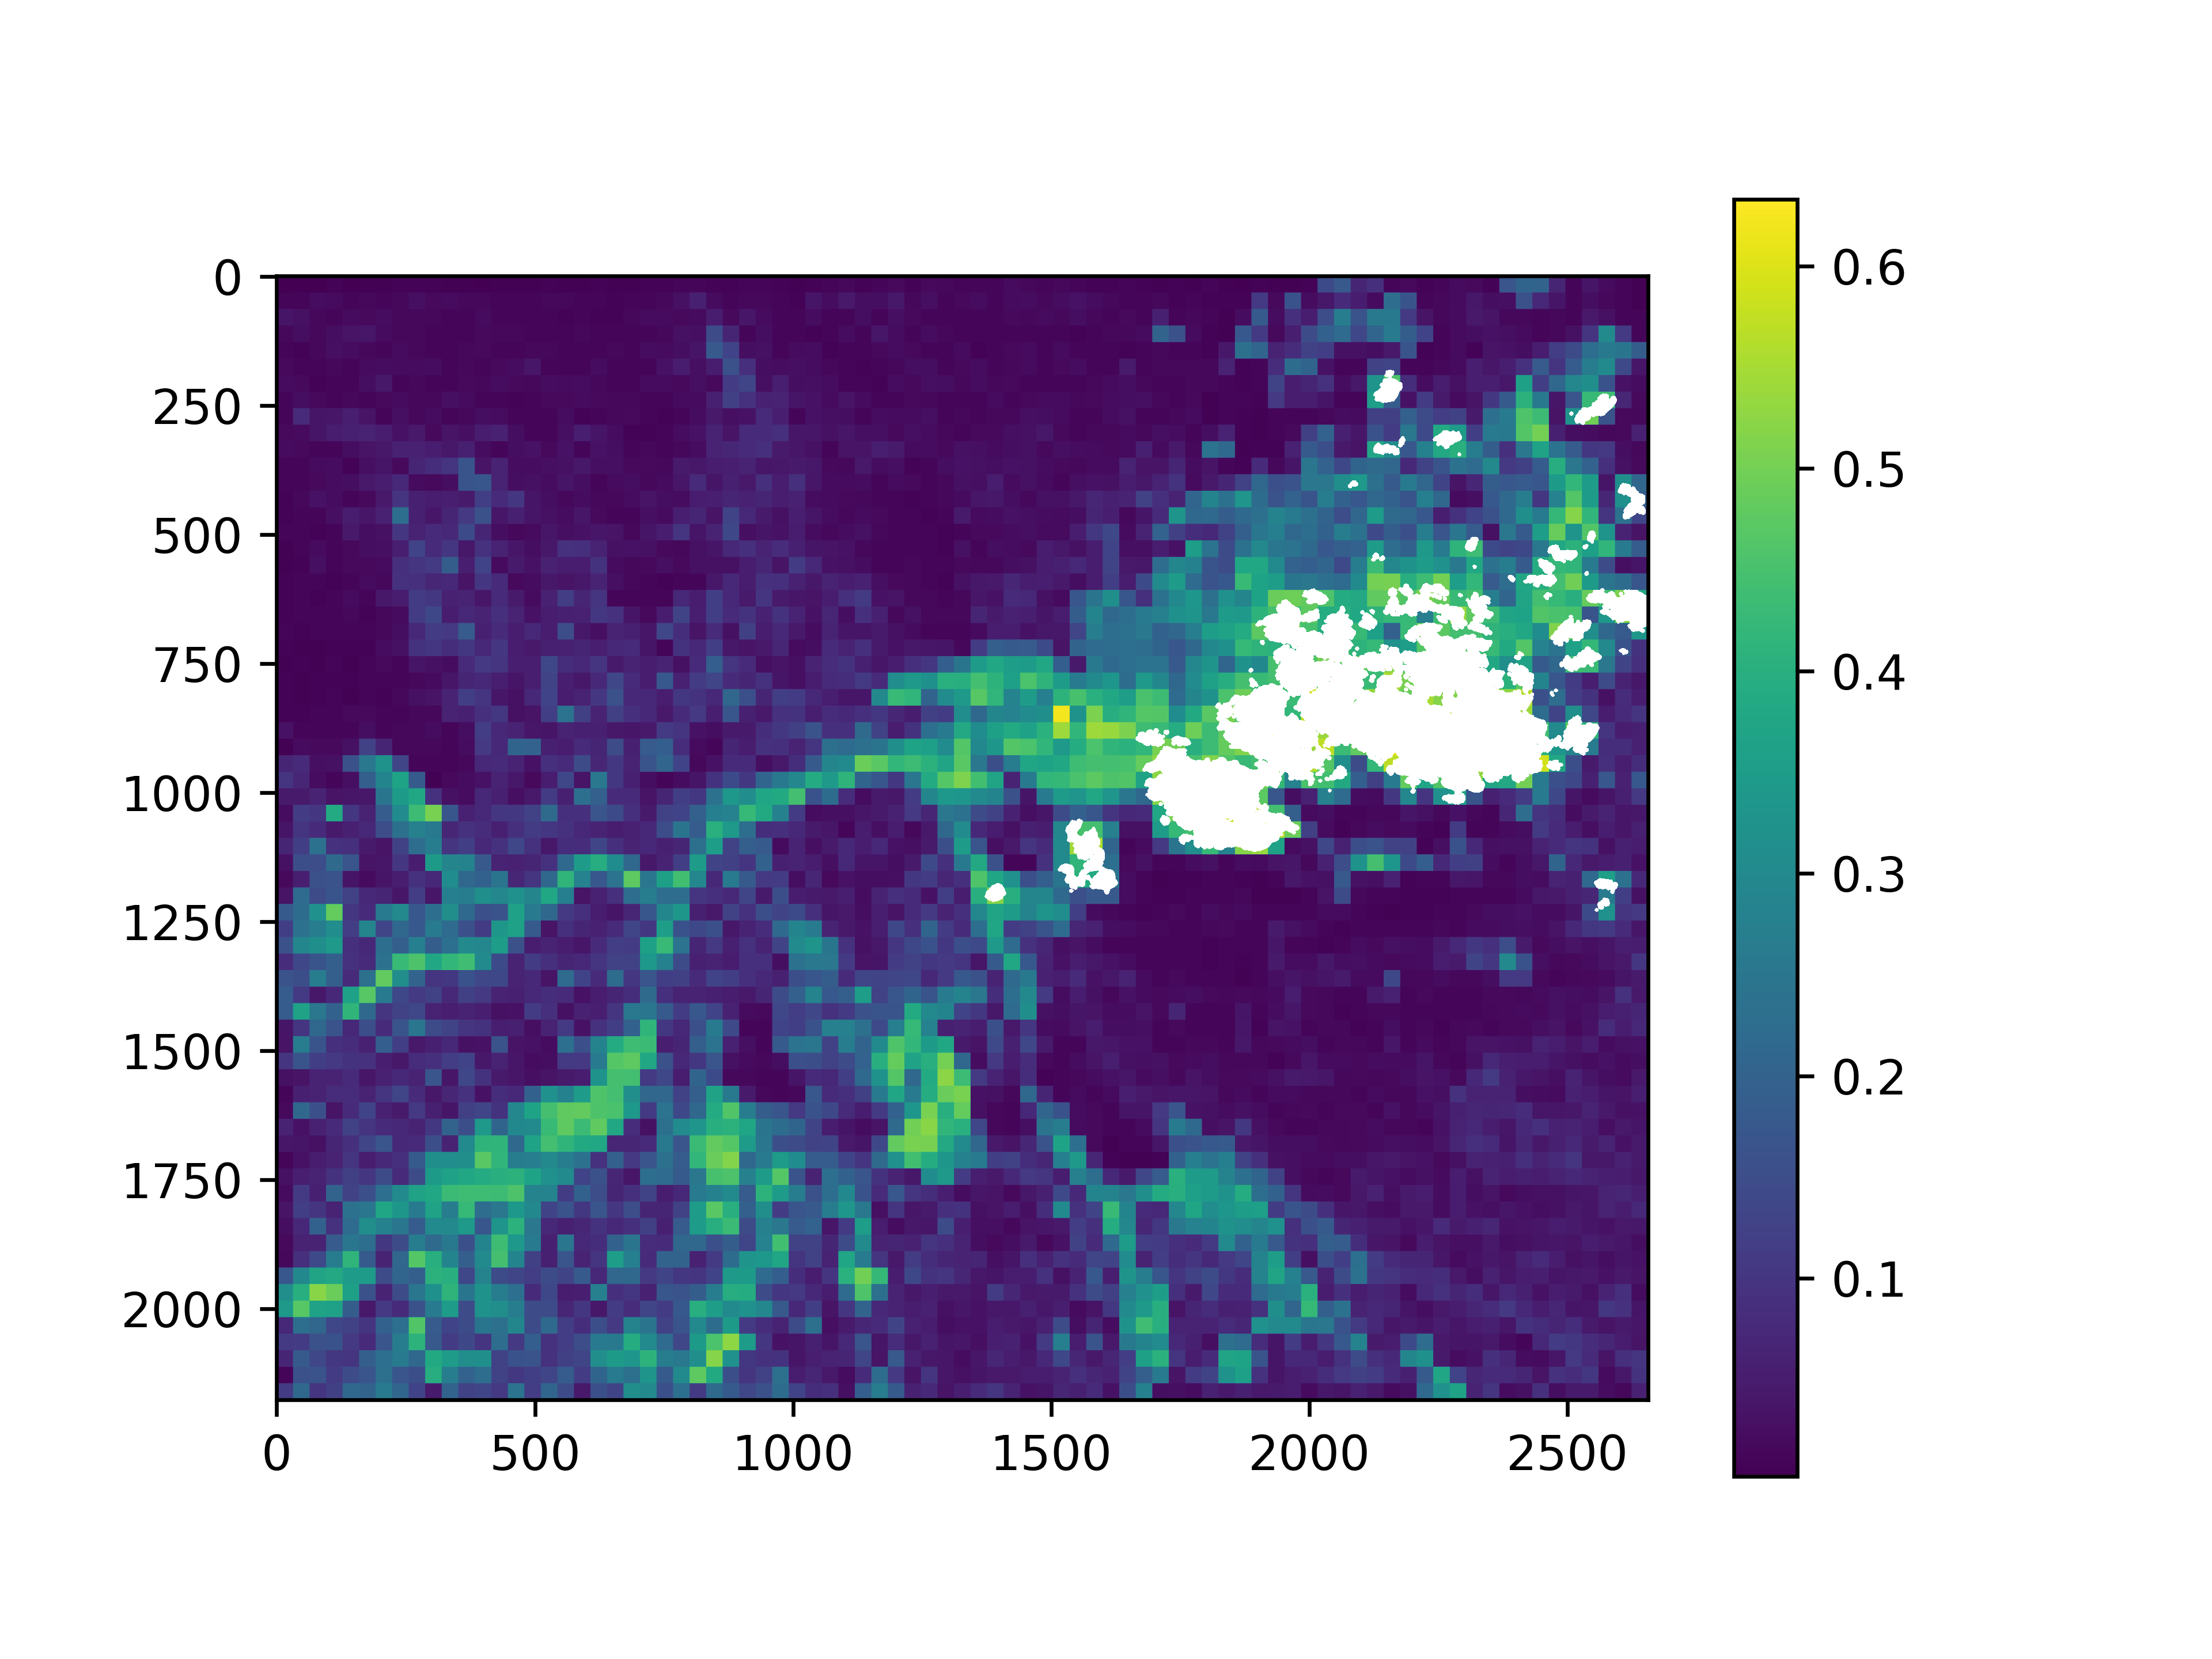

In [19]:
print('RAVAEN (cosine distance of learned embedded tiles, with memory 3)')
Image("./outputs/"+str(index).zfill(3)+"_11_cos_emb | memory 3 | 32x32 - mean.png",
      height=400)

Quantitative results (for the selected single index) are available in the csv files. To access the overall results for this subset see the *'Detection technique summary statistics'* table on wandb.

In [23]:
import pandas as pd 
df=pd.read_csv("./outputs/"+str(index).zfill(3)+"_stats.csv")
df

,Unnamed: 0,cos_pixel | memory 1 | 32x32 - mean,diff_pixels | memory 1 | 32x32 - mean,cos_emb | memory 1 | 32x32 - mean,diff_emb | memory 1 | 32x32 - mean,KLDivEmbeddingImage | memory None | 32x32 - None,WasserEmbeddingImage | memory None | 32x32 - None,cos_pixel | memory 3 | 32x32 - mean,cos_emb | memory 3 | 32x32 - mean
0,area under precision recall curve,0.361155,0.447512,0.513181,0.551789,0.412054,0.551903,0.345828,0.492414
1,precision at 100% recall,0.079720,0.079057,0.079130,0.080063,0.079043,0.080063,0.079839,0.079130


Optionally download the results:

In [ ]:
!zip -r RAVAEN_paper_predictions.zip outputs/

In [ ]:
!ls *.zip -luah

In [ ]:
from google.colab import files
files.download('RAVAEN_paper_predictions.zip') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>